# Pertemuan 16
- Load Preprocessing & Feature Extraction Class as Module
- Load Postprocessing, Training & Detection Class as Module
- Layouting Training
- Layouting Detection

In [1]:
import os
import cv2
import json
import shutil
import numpy as np
import PySimpleGUI as sg 
import matplotlib.pyplot as plt

## 1. Load Preprocessing & Feature Extraction Class as Module

- File `CoreService.py` menyimpan Class `Preprocessing()` dan `FeatureExtration()`
- Dua class tersebut dapat digunakan dengan cara import module (seperti import library)

In [2]:
from CoreService import Preprocessing
from CoreService import FeatureExtraction

- Create Object Preprocessing & Run Preprocessing Data

In [22]:
Prepro = Preprocessing(DATASET_FOLDER = "Dataset_Tomat/")

In [23]:
Prepro.ImageRead()
Prepro.RangeTresholding()
Prepro.EdgeDetection()
Prepro.FindContour()
Prepro.FilterContour()

In [24]:
Prepro.CropByContour()
Prepro.Resize()

In [25]:
Prepro.SaveAllImage(RESIZED_FOLDER = "resized_tomato/")

- Create Object Feature Extraction & Run Feature Extration Data

In [26]:
Feature = FeatureExtraction(PREPROCESSED_DATASET_FOLDER = "resized_tomato/")

In [27]:
Feature.ImageRead()
Feature.CalcStatisticalFeature()

In [28]:
Feature.CalcGLCMMatrix()
Feature.CalcGLCMTextureFeature()

# 2. Load, Postprocessing, Train  & Detection Class as Module

- File `CoreService.py` menyimpan Class `Postprocessing()`, `TrainingMLP()` dan Class `Prediction()`
- Tiga class tersebut dapat digunakan dengan cara import module (seperti import library)

In [3]:
from CoreService import Postprocessing
from CoreService import TrainingMLP
from CoreService import Prediction

- Create object Postprocessing

In [30]:
Postpro = Postprocessing(Feature.statistical_features, 
                         Feature.glcm_feature_list, 
                         Feature.labels)

Postpro.transformX()
Postpro.transformY()
Postpro.splitData()

X size :
 (200, 57)
labels_name :
 ['Defect' 'Good']
y size :
 (200,)
Split size :
 (150, 57) (50, 57) (150,) (50,)


- Create object Training

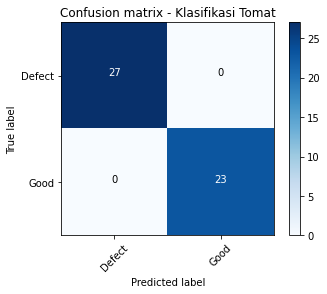

              precision    recall  f1-score   support

      Defect       1.00      1.00      1.00        27
        Good       1.00      1.00      1.00        23

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [31]:
Training = TrainingMLP(Postpro.X_train, 
                       Postpro.y_train, 
                       Postpro.X_test, 
                       Postpro.y_test, 
                       Postpro.labels_vec, 
                       Postpro.labels_name, 
                       max_iteartion=100, 
                       min_accuracy=0.9)

Training.train()
Training.validate(title='Confusion matrix - Klasifikasi Tomat')

- Create Object Predict

In [33]:
sample = np.array([Postpro.X_test[4]]) # get one sample from X_test data

Predict = Prediction(Postpro.labels_name, model_name = "klasifikasi_tomat_mlp_model.xml")
Predict.predict(sample)

Predicted Label : Good (100%)


## Previouse Implementation

In [34]:
# Layout Predict Data
def layout_PredictData():
    return [[sg.Text("Under Development")]]

In [35]:
# Layout Train Model
def layout_TrainingModel():
    return [[sg.Text("Under Development")]]

In [36]:
# Layout Feature Extraction
def layout_FeatureExtraction_left():
    return [
                [
                    sg.Text("Preprocessed Folder", key="preprocess_label"),
                    sg.In(size=(25, 1), enable_events=True, key="Preprocess_Folder"),
                    sg.FolderBrowse(),
                ],
                [
                    sg.Listbox(values=[], enable_events=True, size=(40, 20), key="Preprocess_File_List")
                ],
            ]

def layout_FeatureExtraction_right():
    return [
                [sg.Button("Run Feature Extraction", key="feature_extraction"), sg.Button("  Reset  ", key="feature_reset", visible=False)],
                [
                    sg.Column([[
                                sg.Text("<no feature to show>", 
                                        key="feature_output", 
                                        size=(50,100), 
                                        background_color="#f0f3f7", 
                                        text_color="#000000")
                            ]], scrollable=True, vertical_scroll_only=True, size=(400,350))
                ]
            ]

def layout_FeatureExtraction(): 
    return [
                [
                    sg.Column(layout_FeatureExtraction_left()),
                    sg.VSeperator(),
                    sg.Column(layout_FeatureExtraction_right()),
                ]
            ]

In [37]:
# Layout Preprocessing
def layout_Preprocessing_left():
    return [
                [
                    sg.Text("Dataset Folder", key="label_browse"),
                    sg.In(size=(25, 1), enable_events=True, key="Dataset_Folder"),
                    sg.FolderBrowse(),
                ],
                [
                    sg.Listbox(values=[], enable_events=True, size=(40, 20), key="File_List")
                ],
            ]

def layout_Preprocessing_right():
    return [
                [sg.Button("Run Preprocessing", key="preprocessing"), sg.Button("  Reset  ", key="reset", visible=False)],
                [sg.Image(filename='empty.png', key="image_data")]
            ]

def layout_Preprocessing(): 
    return [
                [
                    sg.Column(layout_Preprocessing_left()),
                    sg.VSeperator(),
                    sg.Column(layout_Preprocessing_right()),
                ]
            ]

In [38]:
# Main Layout

def Layout():
    return [[sg.TabGroup([
                    [sg.Tab('Predict Data', layout_PredictData()), 
                     sg.Tab('Training Model', layout_TrainingModel()),
                     sg.Tab('Feature Extraction', layout_FeatureExtraction()), 
                     sg.Tab('Preprocessing', layout_Preprocessing())]
                    ])
           ]]

In [39]:
# Funtion Convert Matrix Img to Byte
def ImgToByte(filename):
    img = cv2.imread(filename) 
    ret, frame_png = cv2.imencode('.png', img)
    img_byte = frame_png.tobytes()
    return img_byte

In [40]:
def GetFileList(root_folder):
    # baca seluruh file & folder untuk root folder yang di browse
    try :
        file_paths = []
        for folder in os.listdir(root_folder):
            for file in os.listdir(os.path.join(root_folder, folder)):
                path = os.path.join(folder, file)
                file_paths.append(path)
        return file_paths
    except : 
        return []

In [42]:
# Main Program
global Feature
PREPROCESSED_FOLDER = "resized_tomato/"
window = sg.Window("Tomato Grading Systems", layout=Layout(), margins=(10, 10), finalize=True)
window.set_min_size((800,450))
Original_dataset_Path = ""

while True:
    event, values = window.read(timeout=25)
    if event == "Exit" or event == sg.WIN_CLOSED:
        break
        
    # Event Handler Preprocessing
    if event == "Dataset_Folder":
        # baca root folder yang di browse
        root_folder = values["Dataset_Folder"]
        Original_dataset_Path = root_folder
        file_paths = GetFileList(root_folder)
        
        # update Listbox widget dengan list nama-nama file yang terbaca
        window["File_List"].update(file_paths)
        
    elif event == "File_List":  
        root_folder = values["Dataset_Folder"]
        path = values["File_List"][0]
        file_path = os.path.join(root_folder, path).replace("\\","/")
        img_byte = ImgToByte(filename = file_path)
     
        window['image_data'].update(data=img_byte, size=(500,400)) 
        
    elif event == "preprocessing" :
        root_folder = values["Dataset_Folder"]
        if root_folder == "":
            sg.popup("Please Select Dataset Folder First!") # show Popup if Dataset not selected
        else :
            Prepro = Preprocessing(DATASET_FOLDER = root_folder)
            Prepro.ImageRead()
            Prepro.RangeTresholding()
            Prepro.EdgeDetection()
            Prepro.FindContour()
            Prepro.FilterContour()
            Prepro.CropByContour()
            Prepro.Resize()
            PREPROCESSED_PATH = os.path.join(os.path.dirname(root_folder), PREPROCESSED_FOLDER).replace("\\","/")
            Prepro.SaveAllImage(RESIZED_FOLDER = PREPROCESSED_PATH) 
            sg.popup("Preprocessed data saved in folder %s" % PREPROCESSED_FOLDER) # show Popup to notify preprocessed data saved successfully!
            
            # Cleanup window
            window['image_data'].update(filename="empty.png")
            window['Dataset_Folder'].update(value=PREPROCESSED_PATH)
        
            file_paths = GetFileList(PREPROCESSED_PATH)
            window['File_List'].update(file_paths)
            window['label_browse'].update(value="Preprocessed Folder")
            window['preprocessing'].update(visible=False)
            window['reset'].update(visible=True)
            
    elif event == "reset":
            # Cleanup window
            window['image_data'].update(filename="empty.png")
            window['Dataset_Folder'].update(value=Original_dataset_Path)
        
            file_paths = GetFileList(Original_dataset_Path)
            window['File_List'].update(file_paths)
            window['label_browse'].update(value="Dataset Folder")
            window['preprocessing'].update(visible=True)
            window['reset'].update(visible=False)
     
    
    
    # ---------------------------------------- Event Handler Feature Extrcation --------------------------------------------
    elif event == "Preprocess_Folder":
        # baca root folder yang di browse
        root_folder = values["Preprocess_Folder"]
        file_paths = GetFileList(root_folder)
        
        # update Listbox widget dengan list nama-nama file yang terbaca
        window["Preprocess_File_List"].update(file_paths)
        
    elif event == "Preprocess_File_List":  
        root_folder = values["Preprocess_Folder"]
        path = values["Preprocess_File_List"][0]
        try :
            file_paths = GetFileList(root_folder)
            idx = file_paths.index(path)

            feature_stat = json.dumps(Feature.statistical_features[idx], indent=4, sort_keys=True)
            feature_glcm = json.dumps(Feature.glcm_feature_list[idx], indent=4, sort_keys=True)

            feature = "*"*30 + "\n" + feature_stat + "\n\n" + "*"*30 + "\n" + feature_glcm
            window['feature_output'].update(feature)
        except Exception as e:
            sg.popup(e)
        
    elif event == "feature_extraction" :
        root_folder = values["Preprocess_Folder"]
        if root_folder == "":
            sg.popup("Please Select Preprocessed Folder First!") # show Popup if Dataset not selected
        else :
            Feature = FeatureExtraction(PREPROCESSED_DATASET_FOLDER = root_folder)
            Feature.ImageRead()
            Feature.CalcStatisticalFeature()
            Feature.CalcGLCMMatrix()
            Feature.CalcGLCMTextureFeature()
            sg.popup("Feature Extraction generated successfully! ") # show Popup to notify feature extrcation run successfully!
            
            # Cleanup window
            window['feature_output'].update("<no feature to show>")
            window['feature_extraction'].update(visible=False)
            window['feature_reset'].update(visible=True)
            
    elif event == "feature_reset":
            # Cleanup window
            window['feature_output'].update("<no feature to show>")
            window['feature_extraction'].update(visible=True)
            window['feature_reset'].update(visible=False)
            Feature = None
        
window.close()
try :
    del Feature
except :
    pass

## 4. Layouting Training Model

- Ubah function `layout_TrainingModel()` diatas menjadi seperti berikut,

<img src="resource/Screen2.png" style="width:800px"></img>

In [4]:
# Layout Predict Data
def layout_PredictData():
    return [[sg.Text("Under Development")]]

In [5]:
# Layout Train Model

def layout_TrainingModel_left():
    return [[sg.Text("Confusion Matrix")],
            [sg.Image(filename='empty.png', key="confusion_matrix", size=(375,300))]]

def layout_TrainingModel_right():
    return [[sg.Text("Classification Report")],
            [sg.Text("", key="classification_report", size=(50,20), justification="right")]]

def layout_TrainingModel():
    return [
                [ 
                sg.Text("Training Model MLP"),
                sg.Button("Run Training Model", key="training"),
                sg.Button("Run Validation Model", key="validate", visible=False),
                sg.Button("  Reset  ", key="training_reset", visible=False)
                ],
                [
                    sg.Column(layout_TrainingModel_left()),
                    sg.VSeperator(),
                    sg.Column(layout_TrainingModel_right()),
                ]
           ]

In [6]:
# Layout Feature Extraction
def layout_FeatureExtraction_left():
    return [
                [
                    sg.Text("Preprocessed Folder", key="preprocess_label"),
                    sg.In(size=(25, 1), enable_events=True, key="Preprocess_Folder"),
                    sg.FolderBrowse(),
                ],
                [
                    sg.Listbox(values=[], enable_events=True, size=(40, 20), key="Preprocess_File_List")
                ],
            ]

def layout_FeatureExtraction_right():
    return [
                [sg.Button("Run Feature Extraction", key="feature_extraction"), sg.Button("  Reset  ", key="feature_reset", visible=False)],
                [
                    sg.Column([[
                                sg.Text("<no feature to show>", 
                                        key="feature_output", 
                                        size=(50,100), 
                                        background_color="#f0f3f7", 
                                        text_color="#000000")
                            ]], scrollable=True, vertical_scroll_only=True, size=(400,350))
                ]
            ]

def layout_FeatureExtraction(): 
    return [
                [
                    sg.Column(layout_FeatureExtraction_left()),
                    sg.VSeperator(),
                    sg.Column(layout_FeatureExtraction_right()),
                ]
            ]

In [7]:
# Layout Preprocessing
def layout_Preprocessing_left():
    return [
                [
                    sg.Text("Dataset Folder", key="label_browse"),
                    sg.In(size=(25, 1), enable_events=True, key="Dataset_Folder"),
                    sg.FolderBrowse(),
                ],
                [
                    sg.Listbox(values=[], enable_events=True, size=(40, 20), key="File_List")
                ],
            ]

def layout_Preprocessing_right():
    return [
                [sg.Button("Run Preprocessing", key="preprocessing"), sg.Button("  Reset  ", key="reset", visible=False)],
                [sg.Image(filename='empty.png', key="image_data")]
            ]

def layout_Preprocessing(): 
    return [
                [
                    sg.Column(layout_Preprocessing_left()),
                    sg.VSeperator(),
                    sg.Column(layout_Preprocessing_right()),
                ]
            ]

In [8]:
# Main Layout

def Layout():
    return [[sg.TabGroup([
                    [sg.Tab('Predict Data', layout_PredictData()), 
                     sg.Tab('Training Model', layout_TrainingModel()),
                     sg.Tab('Feature Extraction', layout_FeatureExtraction()), 
                     sg.Tab('Preprocessing', layout_Preprocessing())]
                    ])
           ]]

In [9]:
# Funtion Convert Matrix Img to Byte
def ImgToByte(filename):
    img = cv2.imread(filename) 
    ret, frame_png = cv2.imencode('.png', img)
    img_byte = frame_png.tobytes()
    return img_byte

In [10]:
def GetFileList(root_folder):
    # baca seluruh file & folder untuk root folder yang di browse
    try :
        file_paths = []
        for folder in os.listdir(root_folder):
            for file in os.listdir(os.path.join(root_folder, folder)):
                path = os.path.join(folder, file)
                file_paths.append(path)
        return file_paths
    except : 
        return []

X size :
 (200, 57)
labels_name :
 ['Defect' 'Good']
y size :
 (200,)
Split size :
 (150, 57) (50, 57) (150,) (50,)


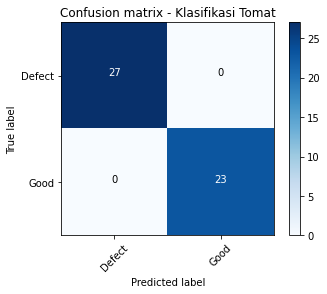

              precision    recall  f1-score   support

      Defect       1.00      1.00      1.00        27
        Good       1.00      1.00      1.00        23

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [11]:
# Main Program
global Feature, Training
PREPROCESSED_FOLDER = "resized_tomato/"
window = sg.Window("Tomato Grading Systems", layout=Layout(), margins=(10, 10), finalize=True)
window.set_min_size((800,450))
Original_dataset_Path = ""

while True:
    event, values = window.read(timeout=25)
    if event == "Exit" or event == sg.WIN_CLOSED:
        break
        
    # Event Handler Preprocessing
    if event == "Dataset_Folder":
        # baca root folder yang di browse
        root_folder = values["Dataset_Folder"]
        Original_dataset_Path = root_folder
        file_paths = GetFileList(root_folder)
        
        # update Listbox widget dengan list nama-nama file yang terbaca
        window["File_List"].update(file_paths)
        
    elif event == "File_List":  
        root_folder = values["Dataset_Folder"]
        path = values["File_List"][0]
        file_path = os.path.join(root_folder, path).replace("\\","/")
        img_byte = ImgToByte(filename = file_path)
     
        window['image_data'].update(data=img_byte, size=(500,400)) 
        
    elif event == "preprocessing" :
        root_folder = values["Dataset_Folder"]
        if root_folder == "":
            sg.popup("Please Select Dataset Folder First!") # show Popup if Dataset not selected
        else :
            Prepro = Preprocessing(DATASET_FOLDER = root_folder)
            Prepro.ImageRead()
            Prepro.RangeTresholding()
            Prepro.EdgeDetection()
            Prepro.FindContour()
            Prepro.FilterContour()
            Prepro.CropByContour()
            Prepro.Resize()
            PREPROCESSED_PATH = os.path.join(os.path.dirname(root_folder), PREPROCESSED_FOLDER).replace("\\","/")
            Prepro.SaveAllImage(RESIZED_FOLDER = PREPROCESSED_PATH) 
            sg.popup("Preprocessed data saved in folder %s" % PREPROCESSED_FOLDER) # show Popup to notify preprocessed data saved successfully!
            
            # Cleanup window
            window['image_data'].update(filename="empty.png")
            window['Dataset_Folder'].update(value=PREPROCESSED_PATH)
        
            file_paths = GetFileList(PREPROCESSED_PATH)
            window['File_List'].update(file_paths)
            window['label_browse'].update(value="Preprocessed Folder")
            window['preprocessing'].update(visible=False)
            window['reset'].update(visible=True)
            
    elif event == "reset":
            # Cleanup window
            window['image_data'].update(filename="empty.png")
            window['Dataset_Folder'].update(value=Original_dataset_Path)
        
            file_paths = GetFileList(Original_dataset_Path)
            window['File_List'].update(file_paths)
            window['label_browse'].update(value="Dataset Folder")
            window['preprocessing'].update(visible=True)
            window['reset'].update(visible=False)
     
    
    
    # ---------------------------------------- Event Handler Feature Extrcation --------------------------------------------
    elif event == "Preprocess_Folder":
        # baca root folder yang di browse
        root_folder = values["Preprocess_Folder"]
        file_paths = GetFileList(root_folder)
        
        # update Listbox widget dengan list nama-nama file yang terbaca
        window["Preprocess_File_List"].update(file_paths)
        
    elif event == "Preprocess_File_List":  
        try :
            root_folder = values["Preprocess_Folder"]
            path = values["Preprocess_File_List"][0]
            file_paths = GetFileList(root_folder)
            idx = file_paths.index(path)

            feature_stat = json.dumps(Feature.statistical_features[idx], indent=4, sort_keys=True)
            feature_glcm = json.dumps(Feature.glcm_feature_list[idx], indent=4, sort_keys=True)

            feature = "*"*30 + "\n" + feature_stat + "\n\n" + "*"*30 + "\n" + feature_glcm
            window['feature_output'].update(feature)
        except Exception as e:
            sg.popup(e)
        
    elif event == "feature_extraction" :
        root_folder = values["Preprocess_Folder"]
        if root_folder == "":
            sg.popup("Please Select Preprocessed Folder First!") # show Popup if Dataset not selected
        else :
            Feature = FeatureExtraction(PREPROCESSED_DATASET_FOLDER = root_folder)
            Feature.ImageRead()
            Feature.CalcStatisticalFeature()
            Feature.CalcGLCMMatrix()
            Feature.CalcGLCMTextureFeature()
            sg.popup("Feature Extraction generated successfully! ") # show Popup to notify feature extrcation run successfully!
            
            # Cleanup window
            window['feature_output'].update("<no feature to show>")
            window['feature_extraction'].update(visible=False)
            window['feature_reset'].update(visible=True)
            
    elif event == "feature_reset":
            # Cleanup window
            window['feature_output'].update("<no feature to show>")
            window['feature_extraction'].update(visible=True)
            window['feature_reset'].update(visible=False)
            Feature = None
            
            
    # ---------------------------------------- Event Handler Training Model --------------------------------------------
    elif event == "training" :

        try :
            Postpro = Postprocessing(Feature.statistical_features, 
                                     Feature.glcm_feature_list, 
                                     Feature.labels)
            Postpro.transformX()
            Postpro.transformY()
            Postpro.splitData()

            Training = TrainingMLP(Postpro.X_train, 
                                   Postpro.y_train, 
                                   Postpro.X_test, 
                                   Postpro.y_test, 
                                   Postpro.labels_vec, 
                                   Postpro.labels_name, 
                                   max_iteartion=100, 
                                   min_accuracy=0.9)

            Training.train()
            sg.popup("Training sucessfully executed!")

            window['training'].update(visible=False)
            window['validate'].update(visible=True)
            window['training_reset'].update(visible=False)
        except Exception as e:
            sg.popup(e)
        
    elif event == "validate" :
        title = 'Confusion matrix - Klasifikasi Tomat'
        Training.validate(title=title)
        
        # update confusion matrix
        img_byte = ImgToByte(filename = title + ".png")
        window['confusion_matrix'].update(data=img_byte) 
        
        # update classification report
        with open("Report %s.txt" % title, "r") as f :
            window['classification_report'].update(f.read())
        
        window['training'].update(visible=False)
        window['validate'].update(visible=False)
        window['training_reset'].update(visible=True)
        
        
window.close()
try :
    del Feature
except :
    pass

## 5. Layouting Prediction

- Ubah function `layout_PredictDate()` diatas menjadi seperti berikut,<br>
<img src="resource/Screen1.png" style="width:800px"></img>

In [5]:
# Layout Predict Data
def layout_PredictData_left():
    return [
                [
                    sg.Text("Browse Image"),
                    sg.In(size=(25, 1), enable_events=True, key="Path_Image"),
                    sg.FileBrowse(file_types=(("Image", "*.png"),("Image", "*.jpg"))),
                ],
                [sg.Text("Original Image", key="sample_label", size=(25,1))],
                [
                    sg.Image(filename='empty.png', key="Sample_Image", size=(375,300)) 
                ]
        ]

def layout_PredictData_right():
    return [
                [sg.Button(" Run Prediction ", key="predict_data"), sg.Button("  Reset  ", key="prediction_reset")],
                [
                    sg.Column([[
                                sg.Text("<no feature to show>", 
                                        key="feature_result", 
                                        size=(50,100), 
                                        background_color="#f0f3f7", 
                                        text_color="#000000")
                            ]], scrollable=True, vertical_scroll_only=True, size=(400,300))
                ],
                [sg.Text("Prediction Result", size=(25,1))],
                [
                   sg.Text("N/A", key="prediction_result", font=("Calibri", 14), size=(50,1))
                ]
            ]

def layout_PredictData():
    return [
                [                    
                    sg.Column(layout_PredictData_left()),
                    sg.VSeperator(),
                    sg.Column(layout_PredictData_right())
                ]
            ]

In [6]:
# Layout Train Model

def layout_TrainingModel_left():
    return [[sg.Text("Confusion Matrix")],
            [sg.Image(filename='empty.png', key="confusion_matrix", size=(375,300))]]

def layout_TrainingModel_right():
    return [[sg.Text("Classification Report")],
            [sg.Text("", key="classification_report", size=(50,20), justification="right")]]

def layout_TrainingModel():
    return [
                [ 
                sg.Text("Training Model MLP"),
                sg.Button("Run Training Model", key="training"),
                sg.Button("Run Validation Model", key="validate", visible=False),
                sg.Button("  Reset  ", key="training_reset", visible=False)
                ],
                [
                    sg.Column(layout_TrainingModel_left()),
                    sg.VSeperator(),
                    sg.Column(layout_TrainingModel_right()),
                ]
           ]

In [7]:
# Layout Feature Extraction
def layout_FeatureExtraction_left():
    return [
                [
                    sg.Text("Preprocessed Folder", key="preprocess_label"),
                    sg.In(size=(25, 1), enable_events=True, key="Preprocess_Folder"),
                    sg.FolderBrowse(),
                ],
                [
                    sg.Listbox(values=[], enable_events=True, size=(40, 20), key="Preprocess_File_List")
                ],
            ]

def layout_FeatureExtraction_right():
    return [
                [sg.Button("Run Feature Extraction", key="feature_extraction"), sg.Button("  Reset  ", key="feature_reset", visible=False)],
                [
                    sg.Column([[
                                sg.Text("<no feature to show>", 
                                        key="feature_output", 
                                        size=(50,100), 
                                        background_color="#f0f3f7", 
                                        text_color="#000000")
                            ]], scrollable=True, vertical_scroll_only=True, size=(400,350))
                ]
            ]

def layout_FeatureExtraction(): 
    return [
                [
                    sg.Column(layout_FeatureExtraction_left()),
                    sg.VSeperator(),
                    sg.Column(layout_FeatureExtraction_right()),
                ]
            ]

In [8]:
# Layout Preprocessing
def layout_Preprocessing_left():
    return [
                [
                    sg.Text("Dataset Folder", key="label_browse"),
                    sg.In(size=(25, 1), enable_events=True, key="Dataset_Folder"),
                    sg.FolderBrowse(),
                ],
                [
                    sg.Listbox(values=[], enable_events=True, size=(40, 20), key="File_List")
                ],
            ]

def layout_Preprocessing_right():
    return [
                [sg.Button("Run Preprocessing", key="preprocessing"), sg.Button("  Reset  ", key="reset", visible=False)],
                [sg.Image(filename='empty.png', key="image_data")]
            ]

def layout_Preprocessing(): 
    return [
                [
                    sg.Column(layout_Preprocessing_left()),
                    sg.VSeperator(),
                    sg.Column(layout_Preprocessing_right()),
                ]
            ]

In [9]:
# Main Layout

def Layout():
    return [[sg.TabGroup([
                    [sg.Tab('Predict Data', layout_PredictData()), 
                     sg.Tab('Training Model', layout_TrainingModel()),
                     sg.Tab('Feature Extraction', layout_FeatureExtraction()), 
                     sg.Tab('Preprocessing', layout_Preprocessing())]
                    ])
           ]]

In [10]:
# Funtion Convert Matrix Img to Byte
def ImgToByte(filename, isResize=False):
    img = cv2.imread(filename) 
    img = cv2.resize(img, (0,0), fx=0.5, fy=0.5) if isResize else img
    ret, frame_png = cv2.imencode('.png', img)
    img_byte = frame_png.tobytes()
    return img_byte

In [11]:
def GetFileList(root_folder):
    # baca seluruh file & folder untuk root folder yang di browse
    try :
        file_paths = []
        for folder in os.listdir(root_folder):
            for file in os.listdir(os.path.join(root_folder, folder)):
                path = os.path.join(folder, file)
                file_paths.append(path)
        return file_paths
    except : 
        return []

In [15]:
# Main Program
global Feature, Training
PREPROCESSED_FOLDER = "resized_tomato/"
window = sg.Window("Tomato Grading Systems", layout=Layout(), margins=(10, 10), finalize=True)
window.set_min_size((800,450))
Original_dataset_Path = ""

while True:
    event, values = window.read(timeout=25)
    if event == "Exit" or event == sg.WIN_CLOSED:
        break
        
    # Event Handler Preprocessing
    if event == "Dataset_Folder":
        # baca root folder yang di browse
        root_folder = values["Dataset_Folder"]
        Original_dataset_Path = root_folder
        file_paths = GetFileList(root_folder)
        
        # update Listbox widget dengan list nama-nama file yang terbaca
        window["File_List"].update(file_paths)
        
    elif event == "File_List":  
        root_folder = values["Dataset_Folder"]
        path = values["File_List"][0]
        file_path = os.path.join(root_folder, path).replace("\\","/")
        img_byte = ImgToByte(filename = file_path)
     
        window['image_data'].update(data=img_byte, size=(500,400)) 
        
    elif event == "preprocessing" :
        root_folder = values["Dataset_Folder"]
        if root_folder == "":
            sg.popup("Please Select Dataset Folder First!") # show Popup if Dataset not selected
        else :
            Prepro = Preprocessing(DATASET_FOLDER = root_folder)
            Prepro.ImageRead()
            Prepro.RangeTresholding()
            Prepro.EdgeDetection()
            Prepro.FindContour()
            Prepro.FilterContour()
            Prepro.CropByContour()
            Prepro.Resize()
            PREPROCESSED_PATH = os.path.join(os.path.dirname(root_folder), PREPROCESSED_FOLDER).replace("\\","/")
            Prepro.SaveAllImage(RESIZED_FOLDER = PREPROCESSED_PATH) 
            sg.popup("Preprocessed data saved in folder %s" % PREPROCESSED_FOLDER) # show Popup to notify preprocessed data saved successfully!
            
            # Cleanup window
            window['image_data'].update(filename="empty.png")
            window['Dataset_Folder'].update(value=PREPROCESSED_PATH)
        
            file_paths = GetFileList(PREPROCESSED_PATH)
            window['File_List'].update(file_paths)
            window['label_browse'].update(value="Preprocessed Folder")
            window['preprocessing'].update(visible=False)
            window['reset'].update(visible=True)
            
    elif event == "reset":
            # Cleanup window
            window['image_data'].update(filename="empty.png")
            window['Dataset_Folder'].update(value=Original_dataset_Path)
        
            file_paths = GetFileList(Original_dataset_Path)
            window['File_List'].update(file_paths)
            window['label_browse'].update(value="Dataset Folder")
            window['preprocessing'].update(visible=True)
            window['reset'].update(visible=False)
     
    
    
    # ---------------------------------------- Event Handler Feature Extrcation --------------------------------------------
    elif event == "Preprocess_Folder":
        # baca root folder yang di browse
        root_folder = values["Preprocess_Folder"]
        file_paths = GetFileList(root_folder)
        
        # update Listbox widget dengan list nama-nama file yang terbaca
        window["Preprocess_File_List"].update(file_paths)
        
    elif event == "Preprocess_File_List":  
        root_folder = values["Preprocess_Folder"]
        path = values["Preprocess_File_List"][0]
        try :
            file_paths = GetFileList(root_folder)
            idx = file_paths.index(path)

            feature_stat = json.dumps(Feature.statistical_features[idx], indent=4, sort_keys=True)
            feature_glcm = json.dumps(Feature.glcm_feature_list[idx], indent=4, sort_keys=True)

            feature = "*"*30 + "\n" + feature_stat + "\n\n" + "*"*30 + "\n" + feature_glcm
            window['feature_output'].update(feature)
        except Exception as e:
            sg.popup(e)
        
    elif event == "feature_extraction" :
        root_folder = values["Preprocess_Folder"]
        if root_folder == "":
            sg.popup("Please Select Preprocessed Folder First!") # show Popup if Dataset not selected
        else :
            Feature = FeatureExtraction(PREPROCESSED_DATASET_FOLDER = root_folder)
            Feature.ImageRead()
            Feature.CalcStatisticalFeature()
            Feature.CalcGLCMMatrix()
            Feature.CalcGLCMTextureFeature()
            sg.popup("Feature Extraction generated successfully! ") # show Popup to notify feature extrcation run successfully!
            
            # Cleanup window
            window['feature_output'].update("<no feature to show>")
            window['feature_extraction'].update(visible=False)
            window['feature_reset'].update(visible=True)
            
    elif event == "feature_reset":
            # Cleanup window
            window['feature_output'].update("<no feature to show>")
            window['feature_extraction'].update(visible=True)
            window['feature_reset'].update(visible=False)
            Feature = None
            
            
    # ---------------------------------------- Event Handler Training Model --------------------------------------------
    elif event == "training" :

        try :
            Postpro = Postprocessing(Feature.statistical_features, 
                                     Feature.glcm_feature_list, 
                                     Feature.labels)
            Postpro.transformX()
            Postpro.transformY()
            Postpro.splitData()

            Training = TrainingMLP(Postpro.X_train, 
                                   Postpro.y_train, 
                                   Postpro.X_test, 
                                   Postpro.y_test, 
                                   Postpro.labels_vec, 
                                   Postpro.labels_name, 
                                   max_iteartion=100, 
                                   min_accuracy=0.9)

            Training.train()
            sg.popup("Training sucessfully executed!")

            window['training'].update(visible=False)
            window['validate'].update(visible=True)
            window['training_reset'].update(visible=False)
        except Exception as e:
            sg.popup(e)
        
    elif event == "validate" :
        title = 'Confusion matrix - Klasifikasi Tomat'
        Training.validate(title=title)
        
        # update confusion matrix
        img_byte = ImgToByte(filename = title + ".png")
        window['confusion_matrix'].update(data=img_byte) 
        
        # update classification report
        with open("Report %s.txt" % title, "r") as f :
            window['classification_report'].update(f.read())
        
        window['training'].update(visible=False)
        window['validate'].update(visible=False)
        window['training_reset'].update(visible=True)
        
    # ---------------------------------------- Event Handler Prediction --------------------------------------------
    if event == "Path_Image":
        try :
            global path_image, SAMPLE_FOLDER, SAMPLE_FILE_PATH
            path_image = values["Path_Image"]

            # create sample directory
            SAMPLE_FOLDER = os.path.join(os.path.dirname(path_image), "sample", "app").replace("\\","/")
            if not os.path.exists(SAMPLE_FOLDER) :
                os.makedirs(SAMPLE_FOLDER)
            else : 
                shutil.rmtree(SAMPLE_FOLDER)
                os.makedirs(SAMPLE_FOLDER)

            # copy file
            SAMPLE_FILE_PATH = os.path.join(SAMPLE_FOLDER, os.path.basename(path_image)).replace("\\","/")
            shutil.copy(path_image, SAMPLE_FILE_PATH)

            # show original image
            img_byte = ImgToByte(filename = SAMPLE_FILE_PATH, isResize=True)
            window['Sample_Image'].update(data=img_byte, size=(375,300))
            window['sample_label'].update(value="Original Image")
        except Exception as e :
            sg.popup(e)
        
    if event == "predict_data" :
        try :
            # preprocess file
            XPrepro = Preprocessing(DATASET_FOLDER = os.path.dirname(SAMPLE_FOLDER))
            XPrepro.ImageRead()
            XPrepro.RangeTresholding()
            XPrepro.EdgeDetection()
            XPrepro.FindContour()
            XPrepro.FilterContour()
            XPrepro.CropByContour()
            XPrepro.Resize()
            PREPROCESSED_PATH = os.path.join(os.path.dirname(path_image), "preprocessed_sample/").replace("\\","/")
            XPrepro.SaveAllImage(RESIZED_FOLDER = PREPROCESSED_PATH) 

            # Feature Extraction
            XFeature = FeatureExtraction(PREPROCESSED_DATASET_FOLDER = PREPROCESSED_PATH)
            XFeature.ImageRead()
            XFeature.CalcStatisticalFeature()
            XFeature.CalcGLCMMatrix()
            XFeature.CalcGLCMTextureFeature()

            # Postprocess Data
            XPostpro = Postprocessing(XFeature.statistical_features, 
                                      XFeature.glcm_feature_list, 
                                      None)
            XPostpro.transformX()

            # Predict Data
            sample = np.array([XPostpro.X[0]]) # get one sample from X_test data

            Predict = Prediction(["Defect", "Good"])
            Predict.predict(sample)

            # update preprocessed image widget
            img_byte = ImgToByte(filename = os.path.join(PREPROCESSED_PATH, "app", "app_000.jpg").replace("\\","/"))
            window['Sample_Image'].update(data=img_byte, size=(375,300))
            window['sample_label'].update(value="Preprocessed Image")

            # update feature extraction widget
            try :
                feature_stat = json.dumps(XFeature.statistical_features[0], indent=4, sort_keys=True)
                feature_glcm = json.dumps(XFeature.glcm_feature_list[0], indent=4, sort_keys=True)

                feature = "*"*30 + "\n" + feature_stat + "\n\n" + "*"*30 + "\n" + feature_glcm
                window['feature_result'].update(feature)
            except Exception as e:
                sg.popup(e)

            # update prediction result
            window['prediction_result'].update(Predict.output)
            
        except Exception as e:
            sg.popup(e)
        
window.close()
try :
    del Feature
except :
    pass

X size :
 (1, 57)
Predicted Label : Defect (100%)


In [14]:
XFeature.statistical_features[0]

{'b': {'mean': 24.44507166035695,
  'std': 32.09293833271967,
  'skewness': 1.8342504045956456},
 'g': {'mean': 40.53001622498648,
  'std': 40.27316699121352,
  'skewness': 0.8787375417514895},
 'r': {'mean': 128.2557801514332,
  'std': 104.76608830262768,
  'skewness': -0.2988778773635128}}

In [20]:
print(json.dumps(XFeature.statistical_features[0], indent=4, sort_keys=True))

{
    "b": {
        "mean": 35.86462276906436,
        "skewness": 1.1990091097863402,
        "std": 37.520868005740596
    },
    "g": {
        "mean": 48.12645348837209,
        "skewness": 0.6123098043781386,
        "std": 41.84198879129291
    },
    "r": {
        "mean": 120.27988101676581,
        "skewness": -0.5613170974303893,
        "std": 80.52399222759165
    }
}
